# 3 layer Conv Encoder, LSTM Decoder. 60 day input, 7 day forecast

In [95]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
save_dir = 'models/lstm8'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
data = df.values

In [97]:
num_input = 60
num_out = 7
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)

train_X shape (613, 60, 25)
train_y shape (613, 7, 1)
dev_X shape (77, 60, 25)
dev_y shape (77, 7, 1)
test_X shape (77, 60, 25)
test_y shape (77, 7, 1)
train_y_acc shape (613, 7, 1)
dev_y_acc shape (77, 7, 1)
test_y_acc shape (77, 7, 1)


In [112]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.001
decay = 1e-6
dropout_rate = 0.5
epochs = 200
batch_size = 32

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='linear', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.005)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Conv1D(filters=96, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(LSTM(200, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
model.add(RepeatVector(num_out))

model.add(LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="binary_crossentropy", optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 58, 64)            4864      
_________________________________________________________________
batch_normalization_13 (Batc (None, 58, 64)            256       
_________________________________________________________________
activation_13 (Activation)   (None, 58, 64)            0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 58, 64)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 56, 96)            18528     
_________________________________________________________________
batch_normalization_14 (Batc (None, 56, 96)            384       
_________________________________________________________________
activation_14 (Activation)   (None, 56, 96)            0         
__________

In [113]:
history = model_funcs.train(
    model,
    train_X,
    train_y_acc,
    (dev_X, dev_y_acc),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 200 epochs, 32 batch size
Train on 613 samples, validate on 77 samples
Epoch 1/200
613/613 [==============================] - 5s 8ms/step - loss: 6.1264 - val_loss: 4.1563
Epoch 2/200
613/613 [==============================] - 2s 3ms/step - loss: 3.1175 - val_loss: 2.1813
Epoch 3/200
613/613 [==============================] - 2s 3ms/step - loss: 1.7067 - val_loss: 1.3125
Epoch 4/200
613/613 [==============================] - 2s 3ms/step - loss: 1.0983 - val_loss: 0.9525
Epoch 5/200
613/613 [==============================] - 2s 3ms/step - loss: 0.8553 - val_loss: 0.8103
Epoch 6/200
613/613 [==============================] - 2s 3ms/step - loss: 0.7601 - val_loss: 0.7625
Epoch 7/200
613/613 [==============================] - 2s 3ms/step - loss: 0.7280 - val_loss: 0.7471
Epoch 8/200
613/613 [==============================] - 2s 3ms/step - loss: 0.7121 - val_loss: 0.7365
Epoch 9/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6995 - val_

613/613 [==============================] - 2s 3ms/step - loss: 0.6747 - val_loss: 0.7900
Epoch 81/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6764 - val_loss: 0.8351
Epoch 82/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6757 - val_loss: 0.7646
Epoch 83/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6750 - val_loss: 0.7744
Epoch 84/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6780 - val_loss: 0.7848
Epoch 85/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6848 - val_loss: 0.8906
Epoch 86/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6765 - val_loss: 0.7553
Epoch 87/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6717 - val_loss: 0.8559
Epoch 88/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6663 - val_loss: 0.7974
Epoch 89/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6713 - val_loss: 

Epoch 160/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6991 - val_loss: 0.8861
Epoch 161/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6782 - val_loss: 0.8589
Epoch 162/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6745 - val_loss: 0.8365
Epoch 163/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6592 - val_loss: 0.8205
Epoch 164/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6794 - val_loss: 0.8589
Epoch 165/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6789 - val_loss: 0.8191
Epoch 166/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6681 - val_loss: 0.8588
Epoch 167/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6559 - val_loss: 0.8461
Epoch 168/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6490 - val_loss: 0.8217
Epoch 169/200
613/613 [==============================] - 2s 3ms/step - lo

In [114]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[:, 0].reshape(-1,1)
# utils.plot_results_multiple(predicted_train.tolist(), true_train, num_out)

In [115]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[:, 0].reshape(-1,1)
# utils.plot_results_multiple(predicted_dev.tolist(), true_dev, num_out)

In [116]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[:, 0].reshape(-1,1)
# utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

In [117]:
# print("MSE Train:", mean_squared_error(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
# print("MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
# print("MSE Test:", mean_squared_error(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

In [118]:
print("Acc Train:", utils.direction_accuracy(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("Acc Dev:", utils.direction_accuracy(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("Acc Test:", utils.direction_accuracy(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

Acc Train: 0.49019607843137253
Acc Dev: 0.47368421052631576
Acc Test: 0.47368421052631576


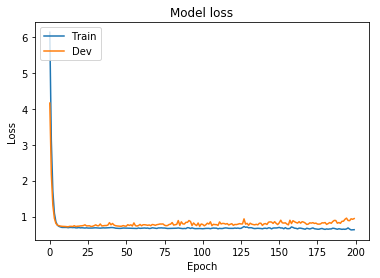

In [119]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()

(613, 1)
(613, 1)
(87,)
0.37394116746332073


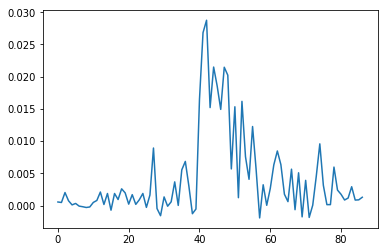

In [106]:
print(true_train.shape)
scores, scores_normalized = utils.get_scores(true_train, predicted_train.reshape(-1,1)[:true_train.shape[0]], num_out)
print(np.sum(scores))
plt.plot(scores)

(77, 1)
(11,)
0.017848397453566273


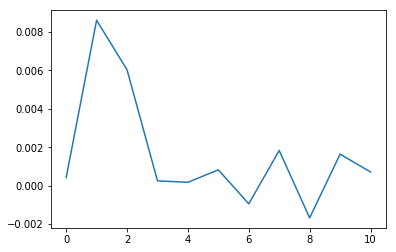

In [109]:
scores, scores_normalized = utils.get_scores(true_dev, predicted_dev.reshape(-1,1), num_out)
print(np.sum(scores))
plt.plot(scores)

(77, 1)
(11,)
-0.006998431845273648


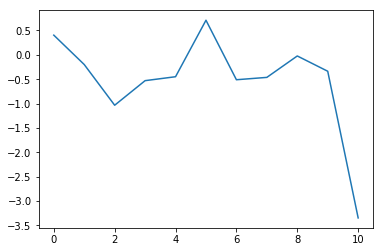

In [110]:
scores, scores_normalized = utils.get_scores(true_test, predicted_test.reshape(-1,1), num_out)
print(np.sum(scores))
plt.plot(mean_score)